c:\Users\dusng\mambaforge\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


<AxesSubplot: >

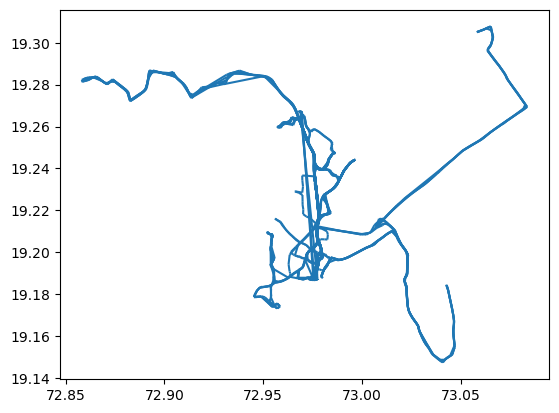

In [37]:
import movingpandas as mpd
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta

routeFile = pd.read_csv("101.csv")
routeFile['directionsss'] = 0
routeFile['location.coordinates'] = routeFile['location.coordinates'].apply(lambda x: x.strip('[]'))
routeFile['location.coordinates.lon'] = routeFile['location.coordinates'].apply(lambda x: x.split(',')[0])
routeFile['location.coordinates.lat'] = routeFile['location.coordinates'].apply(lambda x: x.split(',')[1])
routeFile['PrevTrackDt'] = pd.to_datetime(routeFile['LastTrackdt'])
routeFile.set_index('PrevTrackDt', inplace=True)
routeFilegpd = gpd.GeoDataFrame(routeFile, geometry=gpd.points_from_xy(routeFile['location.coordinates.lon'], routeFile['location.coordinates.lat']))
routeFilegpd = routeFilegpd.set_crs(4326)

my_traj = mpd.Trajectory(routeFilegpd, 'LastTrackdt', 'location.coordinates.lon', 'location.coordinates.lat')
my_traj.plot()
# my_traj.to_linestring()

In [38]:
# split = mpd.SpeedSplitter(my_traj).split(speed=2.4, duration=timedelta(minutes=10))
# traj1=split.trajectories[4]
# print(traj1.get_length())
# my_traj.hvplot(geo=True, tiles='OSM', width=400, height=600, line_width=5, line_color='red', hover_cols=['LastTrackdt', 'location.coordinates.lon', 'location.coordinates.lat','RouteNo'])


In [61]:
import stonesoup
traj2smoothed=mpd.DouglasPeuckerGeneralizer(my_traj).generalize(0.0001)
# traj2smoothed=mpd.KalmanSmootherCV(traj1smoothed).smooth(process_noise_std=0.1, measurement_noise_std=20)
# traj1smoothed.add_direction(overwrite=True)
traj2smoothed.add_direction(overwrite=True)
# traj1smoothed.hvplot(geo=True, tiles='OSM', width=400, height=600, line_width=5, line_color='red', hover_cols=['LastTrackdt', 'location.coordinates.lon', 'location.coordinates.lat','RouteNo', 'direction'])
# traj2smoothed.hvplot(geo=True, tiles='OSM', width=400, height=600, line_width=5, line_color='blue', hover_cols=['LastTrackdt', 'location.coordinates.lon', 'location.coordinates.lat','RouteNo', 'direction'])

c:\Users\dusng\mambaforge\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [62]:

traj2smoothed.df['direction'].hvplot()

:Curve   [PrevTrackDt]   (direction)

In [63]:
traj2smoothed.df['changeindirection'] = 0
for i in range(len(traj2smoothed.df)-1):
    angle = abs(traj2smoothed.df['direction'][i] - traj2smoothed.df['direction'][i+1])
    if (angle > 180):
        angle = 360 - angle
    traj2smoothed.df['changeindirection'][i] = angle

# traj2smoothed.df['changeindirection']=traj2smoothed.df['changeindirection'].apply(lambda x: abs(x))
traj2smoothed.df['changeindirection'].hvplot()


C:\Users\dusng\AppData\Local\Temp\ipykernel_8332\3482189882.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traj2smoothed.df['changeindirection'][i] = angle


:Curve   [PrevTrackDt]   (changeindirection)

In [70]:
splitTimes = []
splitLocations = pd.DataFrame(columns=['location.coordinates.lon', 'location.coordinates.lat'])

for i in range(len(traj2smoothed.df)-1):
    if traj2smoothed.df['changeindirection'][i] > 166 and traj2smoothed.df['changeindirection'][i] < 200:
        # print(traj2smoothed.df['LastTrackdt'][i])
        splitTimes.append(traj2smoothed.df['LastTrackdt'][i])
        # splitLocations.append(my_traj)
        splitLocations=splitLocations.append(my_traj.df.loc[traj2smoothed.df['LastTrackdt'][i] == my_traj.df['LastTrackdt'], ["location.coordinates.lon", "location.coordinates.lat", "LastTrackdt"]])

print(len(splitLocations))

C:\Users\dusng\AppData\Local\Temp\ipykernel_8332\2812984363.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  splitLocations=splitLocations.append(my_traj.df.loc[traj2smoothed.df['LastTrackdt'][i] == my_traj.df['LastTrackdt'], ["location.coordinates.lon", "location.coordinates.lat", "LastTrackdt"]])
C:\Users\dusng\AppData\Local\Temp\ipykernel_8332\2812984363.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  splitLocations=splitLocations.append(my_traj.df.loc[traj2smoothed.df['LastTrackdt'][i] == my_traj.df['LastTrackdt'], ["location.coordinates.lon", "location.coordinates.lat", "LastTrackdt"]])
C:\Users\dusng\AppData\Local\Temp\ipykernel_8332\2812984363.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  splitLocations=

38


C:\Users\dusng\AppData\Local\Temp\ipykernel_8332\2812984363.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  splitLocations=splitLocations.append(my_traj.df.loc[traj2smoothed.df['LastTrackdt'][i] == my_traj.df['LastTrackdt'], ["location.coordinates.lon", "location.coordinates.lat", "LastTrackdt"]])


In [65]:
splitLocationsgdf=gpd.GeoDataFrame(splitLocations, geometry=gpd.points_from_xy(splitLocations['location.coordinates.lon'], splitLocations['location.coordinates.lat']))
splitLocationsgdf = splitLocationsgdf.set_crs(4326)
splitLocationsgdf.hvplot(geo=True, tiles='OSM', width=400, height=600, line_width=5, line_color='red', hover_cols=['location.coordinates.lon', 'location.coordinates.lat', 'LastTrackdt'])

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (location.coordinates.lon,location.coordinates.lat,LastTrackdt)

In [66]:
traj2smoothed.hvplot(geo=True, tiles='OSM', width=400, height=600, line_width=5, line_color='blue', hover_cols=['LastTrackdt', 'location.coordinates.lon', 'location.coordinates.lat','RouteNo', 'changeindirection'])

c:\Users\dusng\mambaforge\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]   (LastTrackdt,location.coordinates.lon,location.coordinates.lat,RouteNo,changeindirection)

In [67]:
splitLocations.head()

,location.coordinates.lon,location.coordinates.lat,LastTrackdt,geometry
2022-09-25 02:16:34+00:00,72.968689,19.267282,2022-09-25T02:16:34.000Z,POINT (72.96869 19.26728)
2022-09-25 20:18:51+00:00,72.955956,19.216061,2022-09-25T20:18:51.000Z,POINT (72.95596 19.21606)
2022-09-25 21:46:57+00:00,72.97522,19.189171,2022-09-25T21:46:57.000Z,POINT (72.97522 19.18917)
2022-09-26 11:44:28+00:00,72.975174,19.186905,2022-09-26T11:44:28.000Z,POINT (72.97517 19.18690)
2022-09-26 14:42:39+00:00,72.978264,19.217068,2022-09-26T14:42:39.000Z,POINT (72.97826 19.21707)
